In [1]:
import pandas as pd
from datetime import datetime

# read in the data files that were downloaded and save as df
test_df = pd.read_csv('../csv/fraudTest.csv')
train_df = pd.read_csv('../csv/fraudTrain.csv')

# remove columns to clean df
column_keep = ['merch_lat', 'merch_long', 'unix_time', 'category', 'amt', 'gender', 'lat', 'long', 'dob', 'is_fraud']

# concat dfs bc we need to use skillet train_test_split
df = pd.concat([train_df, test_df])

# clean merchant column
df['merchant'] = df['merchant'].str.split('_').str[1]

# one end code gender
df['gender'] = df['gender'].replace({'M': 0, 'F': 1})

# Create a new DataFrame with only the selected columns
df = df[column_keep]

# Encode 'category' section in df to be represented numerically (frequency based encoding)
freq_encoding = df['category'].value_counts(normalize=True)
df['category'] = df['category'].map(freq_encoding)

# convert dob to 'age'
current_year = datetime.now().year
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = current_year - df['dob'].dt.year
df.drop('dob', axis=1, inplace=True)

# display the df
df

/var/folders/8q/dh03ws3n0yx6gdjsn87pxb3c0000gn/T/ipykernel_99288/1406138880.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'M': 0, 'F': 1})


,merch_lat,merch_long,unix_time,category,amt,gender,lat,long,is_fraud,age
0,36.011293,-82.048315,1325376018,0.048939,4.97,1,36.0788,-81.1781,0,36
1,49.159047,-118.186462,1325376044,0.095115,107.23,1,48.8878,-118.2105,0,46
2,43.150704,-112.154481,1325376051,0.072403,220.11,0,42.1808,-112.2620,0,62
3,47.034331,-112.561071,1325376076,0.101506,45.00,0,46.2306,-112.1138,0,57
4,38.674999,-78.632459,1325376186,0.061666,41.96,0,38.4207,-79.4629,0,38
...,...,...,...,...,...,...,...,...,...,...
555714,39.946837,-91.333331,1388534347,0.066159,43.77,0,40.4931,-91.8912,0,58
555715,29.661049,-96.186633,1388534349,0.087307,111.84,0,29.0393,-95.4401,0,25
555716,46.658340,-119.715054,1388534355,0.087307,86.88,1,46.1966,-118.9017,0,43
555717,44.470525,-117.080888,1388534364,0.031287,7.99,0,44.6255,-116.4493,0,59


In [2]:
# Scale features down

features_to_scale = ['merch_long', 'merch_lat', 'unix_time', 'lat', 'long', 'amt', 'age']

def standardize(col):
    mean = col.mean()
    std = col.std()
    return (col - mean) / std

for feature in features_to_scale:
    df[feature] = standardize(df[feature])

df

,merch_lat,merch_long,unix_time,category,amt,gender,lat,long,is_fraud,age
0,-0.495080,0.594463,-1.830066,0.048939,-0.408741,1,-0.485167,0.658263,0,-0.845898
1,2.080081,-2.031915,-1.830065,0.095115,0.233378,1,2.040530,-2.035415,0,-0.270874
2,0.903268,-1.593534,-1.830064,0.072403,0.942183,0,0.718034,-1.602730,0,0.649165
3,1.663928,-1.623084,-1.830063,0.101506,-0.157381,0,1.516580,-1.591950,0,0.361653
4,0.026642,0.842714,-1.830057,0.061666,-0.176470,0,-0.023388,0.783024,0,-0.730893
...,...,...,...,...,...,...,...,...,...,...
555714,0.275748,-0.080335,1.641110,0.066159,-0.165105,0,0.385251,-0.120991,0,0.419155
555715,-1.738859,-0.433054,1.641110,0.087307,0.262326,0,-1.873226,-0.379132,0,-1.478425
555716,1.590285,-2.143007,1.641110,0.087307,0.105595,1,1.509876,-2.085692,0,-0.443381
555717,1.161772,-1.951566,1.641111,0.031287,-0.389777,0,1.200084,-1.907308,0,0.476658


In [3]:
from sklearn.model_selection import train_test_split

y = df['is_fraud']
X = df.drop(columns='is_fraud')

# Split data into training set and testing set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# Convert to numpy arrays
Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [4]:
from sklearn.metrics import r2_score
import numpy as np

# Train the model

def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew
# TAKEN FROM MOHIT'S METHOD ON HW4 ^^^

In [33]:
def linreg_classify(Xnew, ynew, m, threshold):
    """
    Args:
        Xnew: Features (input x for all weights)
        ynew: Expected output for feature set
        m: Weights vector
        threshold: Classification threshold

    Returns:
        A dictionary containing:
            'ypreds': The predicted values from applying m to Xnew
            'classified_preds': The classified prediction from the model
            'probabilities': The probabilities (sigmoid of ypreds)
            'resids': The residuals, and the differences between ynew and ypreds
            'mse': The mean squared error
            'r2': The coefficient of determination (R^2)
            'accuracy': Accuracy of model against test set
    """
    # Add bias column
    Xnew_bias = add_bias_column(Xnew)
    
    # Make prediction
    ypreds = np.dot(Xnew_bias, m)

    # Calculate probabilities using sigmoid function
    probabilities = 1 / (1 + np.exp(-ypreds))
    
    # Classify prediction
    classified_preds = (ypreds >= threshold).astype(int)
    
    # Calculate residuals
    resids = ynew - ypreds
    
    # Calculate MSE
    mse = np.mean(resids**2)
    
    # Calculate accuracy against test set
    accuracy = np.mean(classified_preds == ynew)
    
    return {
        'ypreds': ypreds,
        'classified_preds': classified_preds,
        'probabilities': probabilities,
        'resids': resids,
        'mse': mse,
        'accuracy': accuracy
    }
# TAKEN FROM LIAMS HW4
# SLIGHTLY ALTERED

In [6]:
def line_of_best_fit(X, y):
    """
    Args:
        X: A 1-d or 2-d array which includes all the predictor values, not including bias term
        y: a 1-d array which includes all corresponding response values to X

    Returns:
        The vector containing the coeffecients for the line of best fit, including an intercept.
    """
    X_bias = add_bias_column(X)
    
    vector = np.linalg.inv(np.matmul(X_bias.T, X_bias))
    vector = np.matmul(vector, np.matmul(X_bias.T, y))
    
    return vector
# TAKEN FROM LIAMS HW4
# SLIGHTLY ALTERED

In [7]:
def gradient_descent(X, y, weights, alpha=0.0275, max_iter=10000):
    """
    Train the model (converge on a weight vector to minimize MSE via gradient descent)

    Args:
        X: Input vector
        y: expected output vector
        weights: The default initiated weight vector
        alpha: learning rate (default 0.0275, a good, assessed value for fast convergence)
        max_iter: max epoch iterations for training

    Returns:
        The updated weight vector containing the weights and bias of the model
    """
    X_bias = add_bias_column(X)  # Add bias column
    
    for epoch in range(max_iter):
        # Make prediction with current weights
        predicted_y = np.matmul(X_bias, weights)

        # Calculate residuals (We dont use linreg predict for this because its much faster to do manually)
        resids = y - predicted_y

        # Compute gradient using residuals
        gradient = (2 / len(y)) * np.dot(X_bias.T, resids)
        
        # Update weights
        weights += alpha * gradient
        
        # Print progress every 1000 epochs
        if epoch % 1000 == 0:
            mse = np.mean(resids**2)
            print(f"Epoch {epoch}, MSE: {mse:.6f}")
    
    return weights


In [8]:
# Initialize weights as random values for each weight
weights = np.random.rand(Xtrain.shape[1] + 1)  # + 1 to include bias term

# Find good weights using Gradient Descent
weights = gradient_descent(Xtrain, ytrain, weights)

Epoch 0, MSE: 5.259184
Epoch 1000, MSE: 0.005452
Epoch 2000, MSE: 0.005206
Epoch 3000, MSE: 0.005084
Epoch 4000, MSE: 0.005023
Epoch 5000, MSE: 0.004992
Epoch 6000, MSE: 0.004976
Epoch 7000, MSE: 0.004967
Epoch 8000, MSE: 0.004962
Epoch 9000, MSE: 0.004959


In [19]:
# Evaluate the model using test set and a default threshold of 0.5
test_metrics = linreg_classify(Xtest, ytest, weights, 0.5)

# Print evaluation results
print("-----")
print(f"Test MSE: {test_metrics['mse']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2%}")
print(f"Actual Classified Predictions: {test_metrics['classified_preds']}")
print(f"Expected Classified Values: {ytest}")
print(f"Probabilities: {test_metrics['probabilities']}")

-----
Test MSE: 0.0051
Test Accuracy: 99.46%
Actual Classified Predictions: [0 0 0 ... 0 0 0]
Expected Classified Values: [0 0 0 ... 0 0 0]
Probabilities: [0.50210636 0.50248738 0.50394529 ... 0.50179193 0.50735224 0.50301052]


In [21]:
# Evaluate the model using full data set and a default threshold of 0.5
test_metrics = linreg_classify(X, y, weights, 0.5)

# Print evaluation results
print("-----")
print(f"Test MSE: {test_metrics['mse']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2%}")
print(f"Actual Classified Predictions: {test_metrics['classified_preds']}")
print(f"Expected Classified Values: {ytest}")
print(f"Probabilities: {test_metrics['probabilities']}")

-----
Test MSE: 0.0050
Test Accuracy: 99.47%
Actual Classified Predictions: [0 0 0 ... 0 0 0]
Expected Classified Values: [0 0 0 ... 0 0 0]
Probabilities: [0.49718112 0.50388043 0.50554638 ... 0.50145998 0.49564721 0.50012098]


## Find best threshold for predictions
We do this by plotting the ROC curve which the true positive rate and the false positive rate at all classification thresholds.
We also get the exact, best values, and place them on the graph to show that they are the best.

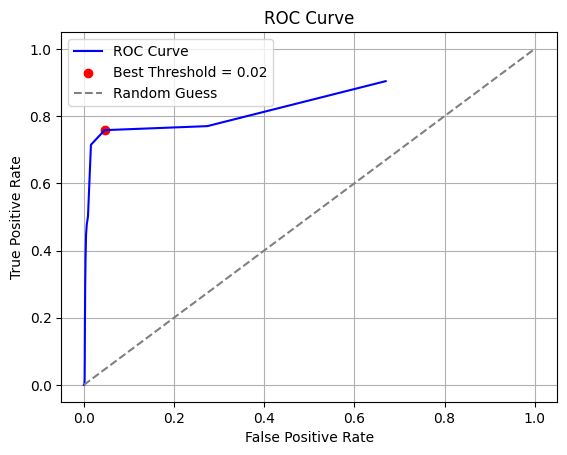

Best Threshold: 0.02
True Positive Rate at Best Threshold: 75.83%
False Positive Rate at Best Threshold: 4.61%


In [32]:
import matplotlib.pyplot as plt

def find_best_threshold_using_roc(y_true, X, m):
    thresholds = np.linspace(0, 1, 101)  # Generate thresholds from 0 to 1
    tprs = []  # True Positive Rates
    fprs = []  # False Positive Rates
    performance = []  # List of performance for each tested threshold

    for threshold in thresholds:
        # Recalculate classifications based on the current threshold
        metrics = linreg_classify(X, y_true, m, threshold=threshold)
        classified_preds = metrics['classified_preds']

        TP = np.sum((y_true == 1) & (classified_preds == 1)) # True Positive
        TN = np.sum((y_true == 0) & (classified_preds == 0)) # True Negative
        FP = np.sum((y_true == 0) & (classified_preds == 1)) # False Positive
        FN = np.sum((y_true == 1) & (classified_preds == 0)) # False Negative

        # Calculate True Positive Rate and False Positive Rate
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        # Append to lists
        tprs.append(TPR)
        fprs.append(FPR)
        performance.append(TPR - FPR)  # Add the performance of each threshold to a list of performances

    # Find the threshold that maximizes the performance
    best_idx = np.argmax(performance)
    best_threshold = thresholds[best_idx]

    # Plot ROC curve
    plt.plot(fprs, tprs, label="ROC Curve", color="blue")
    plt.scatter(fprs[best_idx], tprs[best_idx], color="red", label=f"Best Threshold = {best_threshold:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold, tprs[best_idx], fprs[best_idx]

best_threshold, best_tpr, best_fpr = find_best_threshold_using_roc(y, X, weights)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"True Positive Rate at Best Threshold: {best_tpr:.2%}")
print(f"False Positive Rate at Best Threshold: {best_fpr:.2%}")

In [31]:
# Now, using best threshold, see how it improves the accuracy of our prediction
test_metrics = linreg_classify(X, y, weights, 0.02)

print("-----")
print(f"Test MSE: {test_metrics['mse']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2%}")
print(f"Actual Classified Predictions: {test_metrics['classified_preds']}")
print(f"Expected Classified Values: {ytest}")
print(f"Probabilities: {test_metrics['probabilities']}")


-----
Test MSE: 0.0050
Test Accuracy: 95.29%
Actual Classified Predictions: [0 0 1 ... 0 0 0]
Expected Classified Values: [0 0 0 ... 0 0 0]
Probabilities: [0.49718112 0.50388043 0.50554638 ... 0.50145998 0.49564721 0.50012098]


Using ROC curve to find the best threshold that minimizes the false positive rate and maximizes the true positive rate may have reduced the overall accuracy of our model, but the meaning of this is ambiguous. It may have actually helped our model, because now it is more skeptical of inputted data. Our dataset contains 99% regular, non fraudulent transactions. That means if we simply classify all inputs as not fraud, we'd have 99% accuracy. So, this lower accuracy actually helps our model, because it is more likely to determine that a potentially fraudulent transaction is actually fraudulent.

The point of the ROC is to minimize false positives and maximize true positives. As the graph shows, the threshold found in the function is the best threshold.

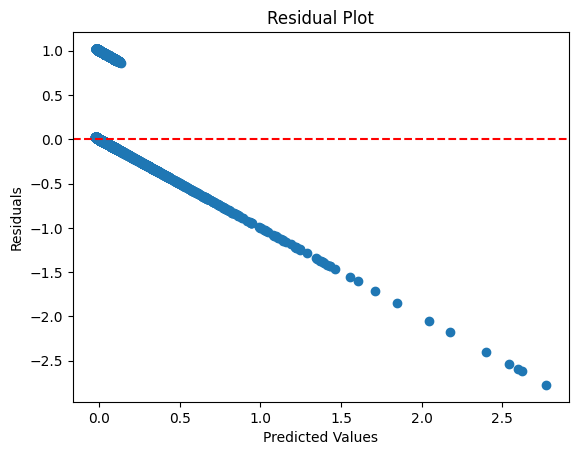

In [34]:
plt.scatter(test_metrics['ypreds'], test_metrics['resids'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

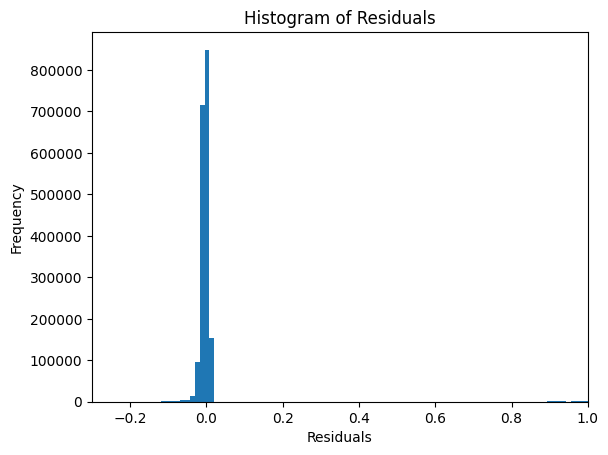

In [35]:
plt.hist(test_metrics['resids'], bins=300)
plt.xlim(-0.3, 1)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Based on the residual plot above we can see that the relationship between the actual values and data is not a linear one, thus fitting them to a line of best fit is not the best model that can be made. Looking at the histogram of residuals, the non-normally distributed data shows that 1) the data from the dataset was fabricated as there is little to no variance and 2) the utilization of a linear regression model is not adequate. However, this does not mean that our model was entirely flawed. The MSE value output by the model was very low, at only 0.0050. This number, being the average squared difference between the observed and predicted values, shows that our model does a very good job at actually predicting what the values should be. Moreover, the model had a test accuracy of 99.48%, which is another indicator that the predicted values are accurate.

We attempted to analyze the underling assumptions of our model using the residual plotting techniques learned for linear regression models. These techniques appeared to reveal that our model was massively flawed in almost every dimension. However, upon further reflection these techniques are ill-suited for checking a model of our type. This is because we are predicting whether a financial action is credit card fraud, which involves classification, not estimation. Because a linear regression model is not best suited for classification data, this is why we see unusual data in our graphs. For example, in the histogram of residuals, we notice that the data is primarily distributed at 0 or 1 and this makes sense as there are only 2 classifications we can use to predict with. Additionally, the residual plot follow a pattern rather than being randomly distributed, indicating that the data is not best fit among aline of best fit and an alternative model would be better suited for this data.

As for the ethical considerations with this model, there are some prevalent ethical issues with this model. Firstly, this model further ingrains the potentially unfair biases inherent in society. By its very nature, the act of predicting whether someone will commit a crime (such as credit card fraud) based on personal information (such as their age, gender, and location) is making an assumption that may not always be true. It is very likely that at least one person would be unfairly mislabeled as a criminal using this model, especially because we explicitly focused on minimizing false negatives at the expense of increasing false positives. As an example from our model, when looking at the weights assigned to each feature we see that the largest weight is assigned to the “gender” category. What this means is that by our model, we would automatically be assuming that someone is much more likely to commit fraud if they are a female as opposed to male.